For the analysis that we had created before, Ricardo and I had noticed that there were some discrepancies in the generation of the descriptive statistics. 

The calculations were being performed properly, however, the dataset that we were using was spread out over too large of an area (Bueno Aires is an area of 200 km$^2$, whereas Sydney's Urban Centre Locality was 3,483 km$^2$. We decided to do the following: 

1. Create a new dataframe that aggregates the data by the hex-ID
2. Perform a spatial join with the newly generated groupby dataframe and then aggregate the statistics from that 
3. Comparing the absolute values of tweets within a hexagon between two periods instead of the percentage change
4. Aggregate the data in two periods, but instead of taking the average of both periods, count the total number of tweets in each period
    * Consider dropping a period of data because of the missing data in 2015. 
5. Cut the lat/lon for the Sydney.plot('')


In [31]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3
import datetime
import matplotlib.pyplot as plt

In [32]:
import importlib
importlib.reload(databasepopulation)
importlib.reload(home)
importlib.reload(a)
importlib.reload(myh3)

<module 'my_h3_functions' from '..\\my_h3_functions.py'>

# 0. Connect to Mongo and define a specific database

In [33]:
db=commu.connecttoLocaldb(database='Twitter_Data')

# 1. Obtaining hexcounts from database

In [34]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

2.2176785469055176


In [35]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,89be08182dbffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89be08184cbffff,1380499200000,1.0,1.0,NaN,1.0,2013-09-30
2,89be08186d3ffff,1419984000000,2.0,2.0,NaN,2.0,2014-12-31
3,89be08191bbffff,1435622400000,2.0,2.0,NaN,2.0,2015-06-30
4,89be081920fffff,1356912000000,3.0,3.0,NaN,3.0,2012-12-31


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206078 entries, 0 to 206077
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          206078 non-null  object        
 1   level_1                      206078 non-null  object        
 2   nonresidents                 204800 non-null  float64       
 3   nonresidentsandnonneighbors  203578 non-null  float64       
 4   residents                    32190 non-null   float64       
 5   totalcounts                  206078 non-null  float64       
 6   time                         206078 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 12.6+ MB


In [37]:
# create a groupby on the time so that we can know which time frames to remove from both periods of analysis 
df.groupby('time').sum()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
time,,,,
2012-09-30,229761.0,211742.0,30339.0,260100.0
2012-12-31,356359.0,323790.0,61568.0,417927.0
2013-03-31,419450.0,380960.0,70364.0,489814.0
2013-06-30,366380.0,331778.0,67054.0,433434.0
2013-09-30,387275.0,356669.0,62135.0,449410.0
2013-12-31,554401.0,509939.0,89274.0,643675.0
2014-03-31,469416.0,429404.0,88440.0,557856.0
2014-06-30,446140.0,402041.0,84390.0,530530.0
2014-09-30,332426.0,303115.0,63688.0,396114.0


Technically, if we were to just count time periods, five quarter (trimestres) after our second observation period is `2015-12-31`, so the equivalent of that from the first time period is `2013-09-30`. I'm going to remove all observations from that time. 

In [38]:
# create variable that is the dt value for our observation period
datebeforeandafterperiod=datetime.datetime(2014,9,30)
# create a dummy variable based on dt value above
df['period']=np.where(df.time>datebeforeandafterperiod,1,0)

In [39]:
df2=df.groupby(['_id','period']).mean()
df2.reset_index(inplace=True)

## 2. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [40]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

# read the new file 
tracts = gpd.read_file(shp_path/"syd.geojson")
# print
tracts = tracts.to_crs('EPSG:4326')

In [41]:
tracts.AREASQKM16.sum()

3482.7441

In [42]:
tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SA2_MAIN16          265 non-null    object  
 1   SA2_5DIG16          265 non-null    object  
 2   SA2_NAME16          265 non-null    object  
 3   SA3_CODE16          265 non-null    object  
 4   SA3_NAME16          265 non-null    object  
 5   SA4_CODE16          265 non-null    object  
 6   SA4_NAME16          265 non-null    object  
 7   GCC_CODE16          265 non-null    object  
 8   GCC_NAME16          265 non-null    object  
 9   STE_CODE16          265 non-null    object  
 10  STE_NAME16          265 non-null    object  
 11  AREASQKM16          265 non-null    float64 
 12  OID                 265 non-null    int64   
 13  SA2_MAINCODE_2016   265 non-null    int64   
 14  rentals_ov100_11    265 non-null    int64   
 15  types               265 non-null

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

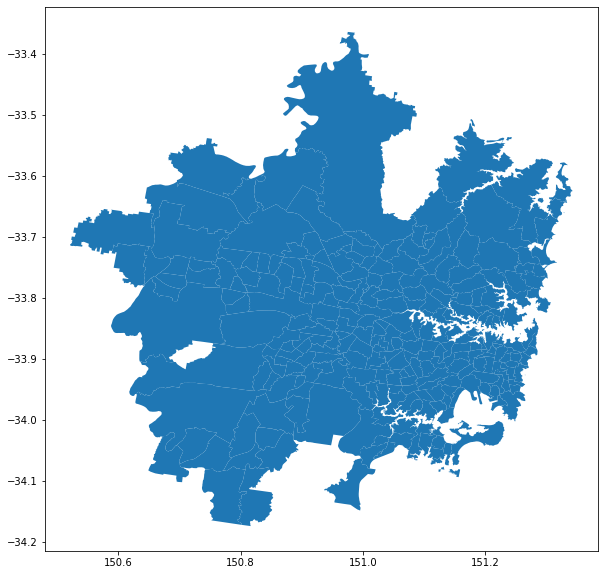

In [43]:
tracts.plot()

tracts.crs

In [44]:
# Create a geodataframe out of the grouped hex dataframe `df2`
gdf = myh3.df_with_hexid_to_gdf(df2, hexcolname='_id')

In [45]:
# Create a dataframe agg_gdf out of the tracts above and the geodataframe we created before 
agg_gdf = gpd.sjoin(gdf,tracts,how='inner',op='intersects')

In [46]:
# Generate a quick pivot table to see the different sums of each of the variables between the different periods
agg_gdf.pivot_table(index='standardized_types', 
                    columns='period', 
                    aggfunc={'nonresidents':sum,
                             'nonresidentsandnonneighbors':sum,
                             'residents':sum,
                             'totalcounts':sum,}, 
                    fill_value=0)

nonresidents                 \
period                                     0              1   
standardized_types                                            
Exclusive Dynamic              126760.717857   63403.153571   
Exclusive Static               164202.314683   81153.868254   
Low Income, At Risk of Change  174668.740079  101342.906746   
Low Income, Stable              30951.303571   15543.724603   
Low Income, Undergoing Change   74703.039683   37706.214683   

                              nonresidentsandnonneighbors                \
period                                                  0             1   
standardized_types                                                        
Exclusive Dynamic                           117302.260317  59521.933333   
Exclusive Static                            150160.904762  75896.707143   
Low Income, At Risk of Change               157350.882937  94847.313492   
Low Income, Stable                           28427.728571  14560.490476   
Low Income, Undergoing Change                68021.564683  35496.351587   

                                  residents                  totalcounts  \
period                                    0             1              0   
standardized_types                                                         
Exclusive Dynamic              32931.017460  17960.517460  147160.717063   
Exclusive Static               48494.886905  25510.990476  194303.364286   
Low Income, At Risk of Change  42214.497222  20729.298413  201396.791667   
Low Income, Stable             11693.785714   6905.158730   36326.401587   
Low Income, Undergoing Change  28525.445635  15615.858333   88798.485317   

                                              
period                                     1  
standardized_types                            
Exclusive Dynamic               72468.494841  
Exclusive Static                95572.023413  
Low Income, At Risk of Change  112988.035714  
Low Income, Stable              18623.919048  
Low Income, Undergoing Change   43900.825794

In [47]:
agg_gdf.pivot_table(index='standardized_types', 
                    columns='period', 
                    aggfunc={'nonresidents':np.median,
                             'nonresidentsandnonneighbors':np.median,
                             'residents':np.median,
                             'totalcounts':np.median,}, 
                    fill_value=0)

nonresidents            \
period                                   0         1   
standardized_types                                     
Exclusive Dynamic                 3.000000  2.000000   
Exclusive Static                  3.444444  2.125000   
Low Income, At Risk of Change     7.666667  3.000000   
Low Income, Stable                2.866071  1.714286   
Low Income, Undergoing Change     6.222222  2.625000   

                              nonresidentsandnonneighbors           residents  \
period                                                  0         1         0   
standardized_types                                                              
Exclusive Dynamic                                2.777778  2.000000  8.000000   
Exclusive Static                                 3.222222  2.000000  9.000000   
Low Income, At Risk of Change                    7.000000  2.875000  9.333333   
Low Income, Stable                               2.666667  1.666667  9.000000   
Low Income, Undergoing Change                    5.666667  2.500000  8.750000   

                                        totalcounts            
period                                1           0         1  
standardized_types                                             
Exclusive Dynamic              5.666667    3.333333  2.125000  
Exclusive Static               6.000000    4.000000  2.333333  
Low Income, At Risk of Change  6.291667    9.111111  3.444444  
Low Income, Stable             6.000000    3.333333  2.000000  
Low Income, Undergoing Change  6.000000    7.555556  3.000000

In [48]:
agg_group = agg_gdf[['nonresidents',
         'nonresidentsandnonneighbors',
                     'residents','totalcounts',
         'standardized_types','period']].groupby(['standardized_types','period']).agg(['mean',
                                            'median',
                                            'count',
                                            'sem'])
agg_group

nonresidents                            \
                                             mean    median count       sem   
standardized_types            period                                          
Exclusive Dynamic             0         24.513773  3.000000  5171  1.373004   
                              1         13.937822  2.000000  4549  0.787426   
Exclusive Static              0         25.911680  3.444444  6337  1.333832   
                              1         14.150631  2.125000  5735  0.756420   
Low Income, At Risk of Change 0         47.854449  7.666667  3650  3.835787   
                              1         29.833061  3.000000  3397  4.968625   
Low Income, Stable            0         11.181829  2.866071  2768  0.529357   
                              1          6.608726  1.714286  2352  0.505596   
Low Income, Undergoing Change 0         20.802851  6.222222  3591  0.880823   
                              1         11.265675  2.625000  3347  0.945488   

                                     nonresidentsandnonneighbors            \
                                                            mean    median   
standardized_types            period                                         
Exclusive Dynamic             0                        22.759461  2.777778   
                              1                        13.116336  2.000000   
Exclusive Static              0                        23.767158  3.222222   
                              1                        13.296550  2.000000   
Low Income, At Risk of Change 0                        43.168967  7.000000   
                              1                        27.986814  2.875000   
Low Income, Stable            0                        10.333598  2.666667   
                              1                         6.219774  1.666667   
Low Income, Undergoing Change 0                        19.027011  5.666667   
                              1                        10.634018  2.500000   

                                                      residents            \
                                     count       sem       mean    median   
standardized_types            period                                        
Exclusive Dynamic             0       5154  1.282508  24.142975  8.000000   
                              1       4538  0.751176  18.985748  5.666667   
Exclusive Static              0       6318  1.225020  27.168004  9.000000   
                              1       5708  0.718242  21.879066  6.000000   
Low Income, At Risk of Change 0       3645  3.464546  31.574044  9.333333   
                              1       3389  4.911448  26.782039  6.291667   
Low Income, Stable            0       2751  0.499862  20.057951  9.000000   
                              1       2341  0.482784  22.639865  6.000000   
Low Income, Undergoing Change 0       3575  0.806739  24.718757  8.750000   
                              1       3338  0.942118  24.905675  6.000000   

                                                     totalcounts            \
                                     count       sem        mean    median   
standardized_types            period                                         
Exclusive Dynamic             0       1364  2.219084   28.332830  3.333333   
                              1        946  1.980049   15.857439  2.125000   
Exclusive Static              0       1785  1.652484   30.613418  4.000000   
                              1       1166  2.261326   16.601012  2.333333   
Low Income, At Risk of Change 0       1337  2.105307   55.086650  9.111111   
                              1        774  3.052213   33.163497  3.444444   
Low Income, Stable            0        583  1.473042   13.081167  3.333333   
                              1        305  3.742920    7.881472  2.000000   
Low Income, Undergoing Change 0       1154  1.712693   24.700552  7.555556   
                              1        627  3.366717   1

In [49]:
agg_group.reset_index(inplace=True)

## Total Tweets by Typology Calculations (Ricardo 2.3)

In [50]:
stats1=agg_gdf[['nonresidents', 'nonresidentsandnonneighbors', 
                'residents', 'totalcounts', 
                'standardized_types']].groupby(['standardized_types']).agg([ 'sum'])

stats1.reset_index(inplace=True)
stats1=stats1.sort_values(by=('totalcounts','sum'), ascending=False)

stats1=stats1.loc[stats1.standardized_types!='OTHER']
stats1

,standardized_types,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
,,sum,sum,sum,sum
2,"Low Income, At Risk of Change",276011.646825,252198.196429,62943.795635,314384.827381
1,Exclusive Static,245356.182937,226057.611905,74005.877381,289875.387698
0,Exclusive Dynamic,190163.871429,176824.193651,50891.534921,219629.211905
4,"Low Income, Undergoing Change",112409.254365,103517.916270,44141.303968,132699.311111
3,"Low Income, Stable",46495.028175,42988.219048,18598.944444,54950.320635


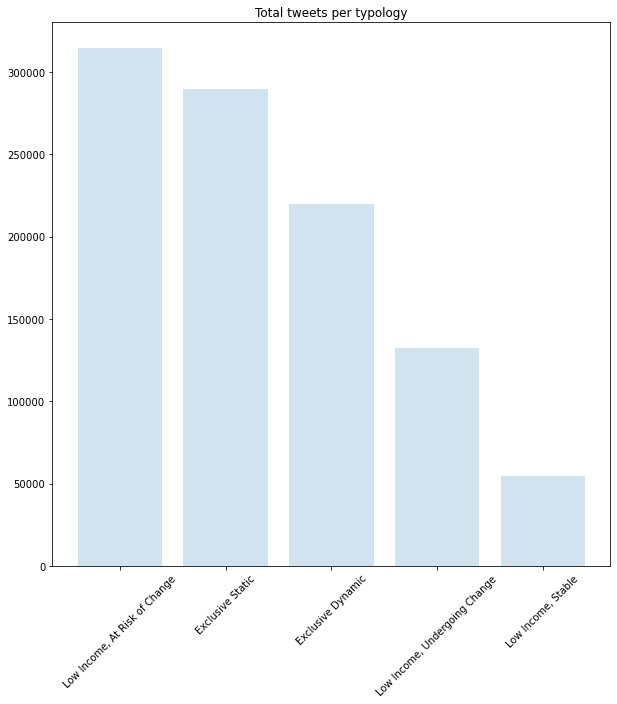

In [53]:
fig, ax = plt.subplots()
ax.bar(stats1['standardized_types'], stats1['totalcounts','sum'], alpha=0.2)
plt.title('Total tweets per typology')
plt.xticks(rotation=45) 
plt.show()

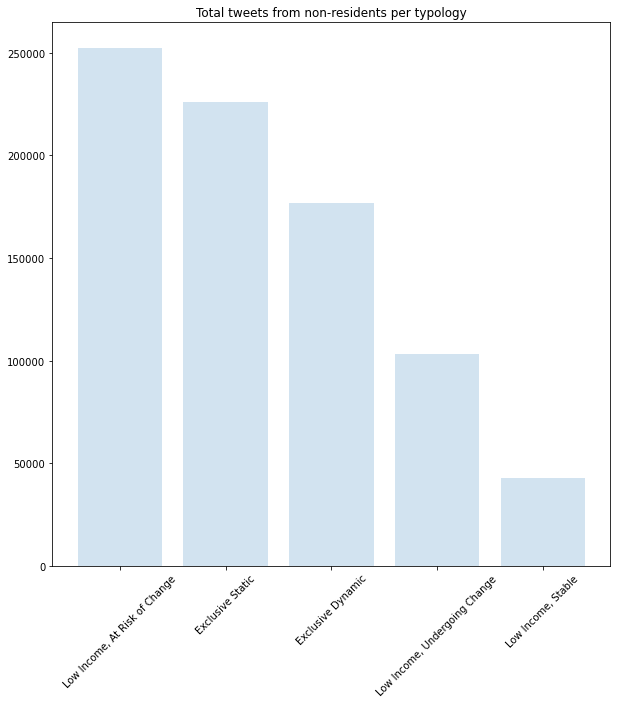

In [54]:
fig, ax = plt.subplots()
plt.title('Total tweets from non-residents per typology')
ax.bar(stats1['standardized_types'], stats1['nonresidentsandnonneighbors','sum'], alpha=0.2)
plt.xticks(rotation=45) 
plt.show()

## 2.4 Hex-level statistics of the total number of tweets (complete period)

In [55]:
stats2=agg_gdf[['nonresidents', 'nonresidentsandnonneighbors', 
                'residents', 'totalcounts', 'standardized_types']
              ].groupby('standardized_types').agg(['mean','sem', 'median', 'count'])

stats2.reset_index(inplace=True)

stats2=stats2.sort_values(by=('nonresidentsandnonneighbors','mean'), ascending=False)

#removing categories from graph
stats2=stats2.loc[stats2.standardized_types!='OTHER']
stats2

standardized_types nonresidents                             \
                                         mean       sem    median  count   
2  Low Income, At Risk of Change    39.167255  3.113502  4.875000   7047   
1               Exclusive Static    20.324402  0.788787  2.714286  12072   
0              Exclusive Dynamic    19.564184  0.819841  2.444444   9720   
4  Low Income, Undergoing Change    16.201968  0.647381  4.000000   6938   
3             Low Income, Stable     9.081060  0.369910  2.111111   5120   

  nonresidentsandnonneighbors                             residents            \
                         mean       sem    median  count       mean       sem   
2                   35.854165  2.971477  4.375000   7034  29.817051  1.741072   
1                   18.797407  0.729823  2.500000  12026  25.078237  1.341296   
0                   18.244345  0.768879  2.333333   9692  22.030967  1.541528   
4                   14.974384  0.619263  3.666667   6913  24.784561  1.623120   
3                    8.442305  0.350708  2.000000   5092  20.944757  1.607969   

                  totalcounts                             
     median count        mean       sem    median  count  
2  8.000000  2111   44.511515  3.261408  5.777778   7063  
1  8.000000  2951   23.948727  0.891770  3.000000  12104  
0  7.000000  2310   22.493774  0.897276  2.666667   9764  
4  7.888889  1781   19.090679  0.715767  4.666667   6951  
3  8.000000   888   10.690724  0.418907  2.375000   5140

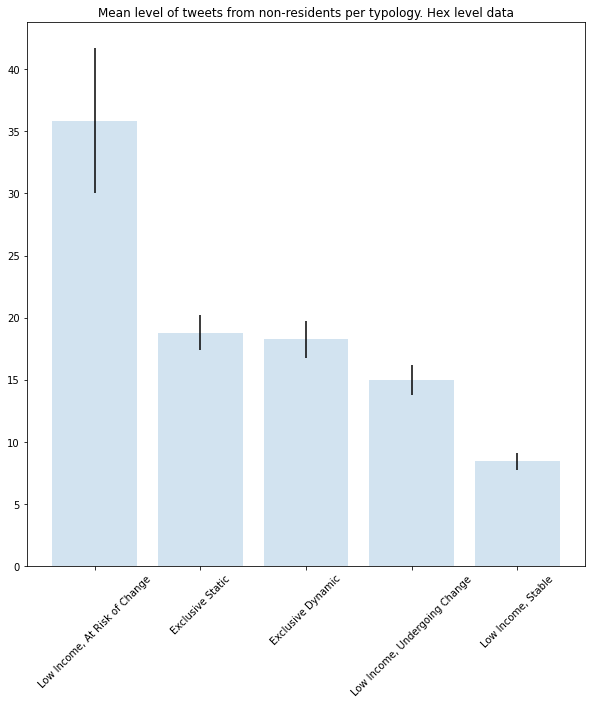

In [56]:
fig, ax = plt.subplots()
plt.title('Mean level of tweets from non-residents per typology. Hex level data')

ax.bar(stats2['standardized_types'], stats2['nonresidentsandnonneighbors','mean'], 
       yerr=1.96*stats2['nonresidentsandnonneighbors','sem'], alpha=0.2)

plt.xticks(rotation=45) 
plt.show()

## 3. Statistics splitting the sample in two time periods and computing time changes (i.e., before-after)

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

### 2.1 Compute changes

Note: changes can be computed by first averaging the quarter level data of each period, or alternatively, by summing the data in each period. We will start by averaging which is the default option in a.percent_change_two_periods function

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206078 entries, 0 to 206077
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   _id                          206078 non-null  object        
 1   level_1                      206078 non-null  object        
 2   nonresidents                 204800 non-null  float64       
 3   nonresidentsandnonneighbors  203578 non-null  float64       
 4   residents                    32190 non-null   float64       
 5   totalcounts                  206078 non-null  float64       
 6   time                         206078 non-null  datetime64[ns]
 7   period                       206078 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), object(2)
memory usage: 13.4+ MB


In [58]:
# 2 Define a midpoint date to separate the two periods in the data. Remember here to change the datetime to the midpoint date in the previous step.
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2014,9,30))

In [59]:
gdfchanges.head(3)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,89be0819e4bffff,-0.400000,-0.400000,NaN,-0.400000,1.400000,1.400000,NaN,1.400000,-0.285714,-0.285714,NaN,-0.285714,NaN,NaN,NaN,NaN,"POLYGON ((150.63652 -33.93275, 150.63603 -33.9..."
1,89be081a053ffff,-0.333333,-0.333333,NaN,-0.333333,0.666667,0.666667,NaN,0.666667,-0.500000,-0.500000,NaN,-0.500000,NaN,NaN,NaN,NaN,"POLYGON ((150.66875 -34.06108, 150.66826 -34.0..."
2,89be081a08bffff,1.333333,1.333333,NaN,1.333333,0.333333,0.333333,NaN,0.333333,4.000000,4.000000,NaN,4.000000,NaN,NaN,NaN,NaN,"POLYGON ((150.66486 -34.07088, 150.66437 -34.0..."


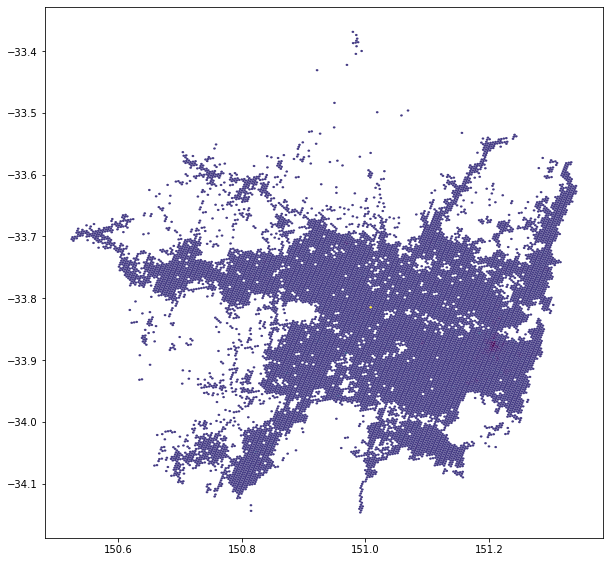

In [60]:
# Plot example
gdfchanges.plot('nonresidents_dif')

### 2.2. Spatial join with census tracks (typologies) data

This requires:

    1. An available function changes the geometry of the gdf to the centroids
    2. Load your typologies data to a geodataframe
    3. Spatial join



In [61]:
#1 Get centroids
gdfchanges_points=myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

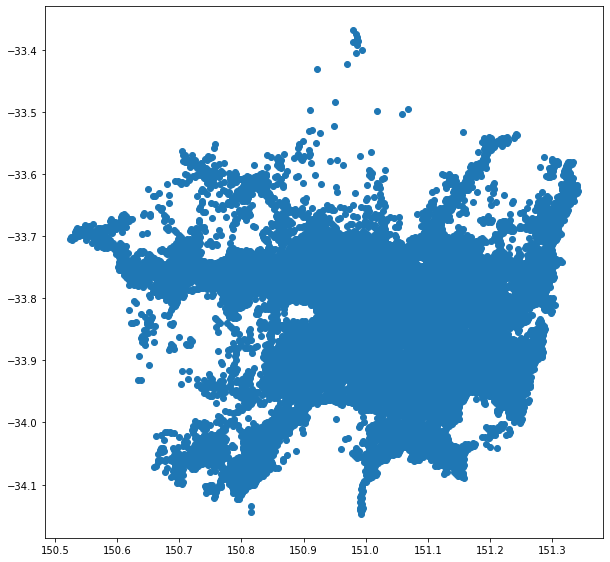

In [62]:
gdfchanges_points.plot()

In [63]:
# 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [64]:
typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 
                          'nonresidents_p0', 'standardized_types']
                        ].groupby('standardized_types').agg(['mean','count','sem'])

typo_stats.reset_index(inplace=True)

In [65]:
typo_stats

standardized_types nonresidents_dif                  \
                                             mean count       sem   
0              Exclusive Dynamic       -14.060833  2921  1.212268   
1               Exclusive Static       -12.839180  3936  1.090817   
2  Low Income, At Risk of Change       -21.016144  2327  6.745199   
3             Low Income, Stable        -6.934203  1576  0.928471   
4  Low Income, Undergoing Change       -13.267152  2250  1.101439   

  nonresidents_ch                 nonresidents_p0                  
             mean count       sem            mean count       sem  
0        0.614573  2921  0.136587       28.738893  2931  2.000481  
1        0.860745  3936  0.143361       26.679305  3950  1.432966  
2        0.636685  2327  0.203408       54.765511  2333  5.587418  
3        1.107880  1576  0.342853       13.756443  1585  0.793065  
4        0.252724  2250  0.093918       23.456593  2257  1.267049

In [66]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], 
           yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

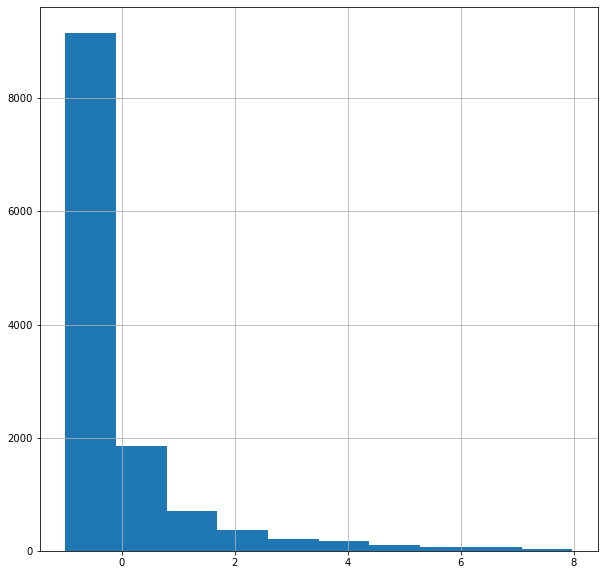

In [67]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

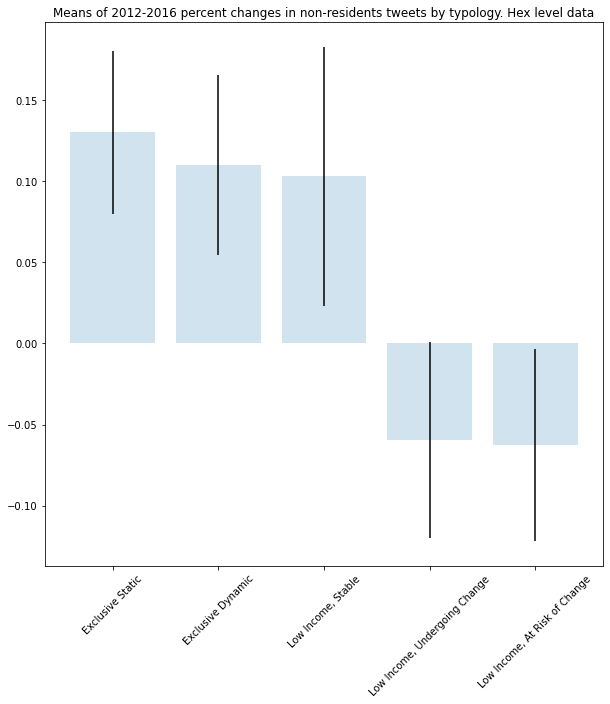

In [68]:
barchart(tweets_tracts, 'nonresidents_ch', 
         title='Means of 2012-2016 percent changes in non-residents tweets by typology. Hex level data')

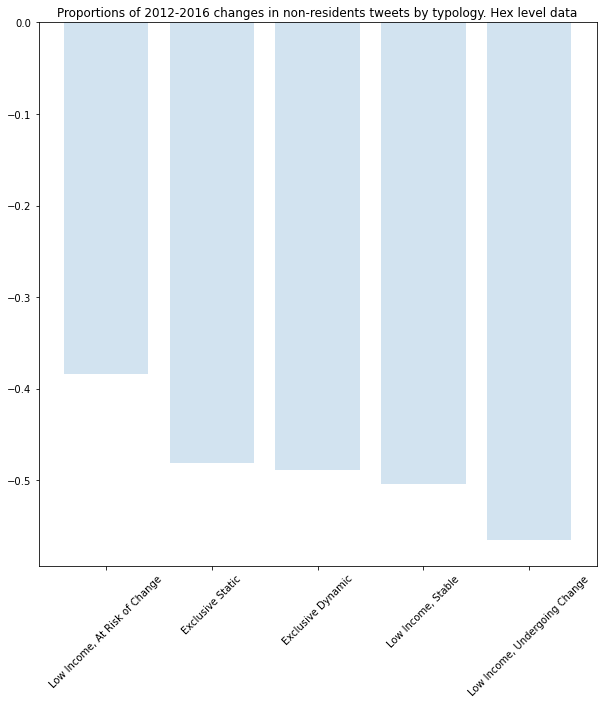

In [69]:
# Create variable proportions to create a bar chart. 
typo_stats['proportions'] = typo_stats['nonresidents_dif','mean']/typo_stats['nonresidents_p0','mean']
typo_stats = typo_stats.sort_values(by=('proportions'), ascending=False)

fig, ax = plt.subplots()
    
ax.bar(typo_stats['standardized_types'], 
       typo_stats['proportions'],
       alpha=0.2)

plt.title('Proportions of 2012-2016 changes in non-residents tweets by typology. Hex level data')
plt.xticks(rotation=45)
plt.show()

## Repeat analysis summing tweets in each period

In [70]:
import analysis as a

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


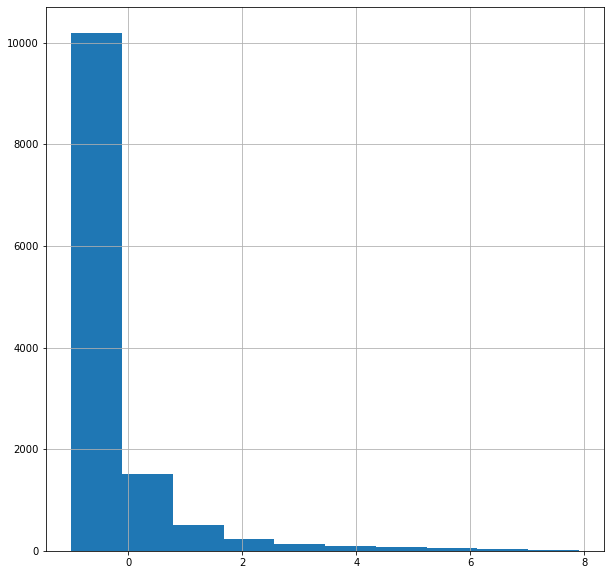

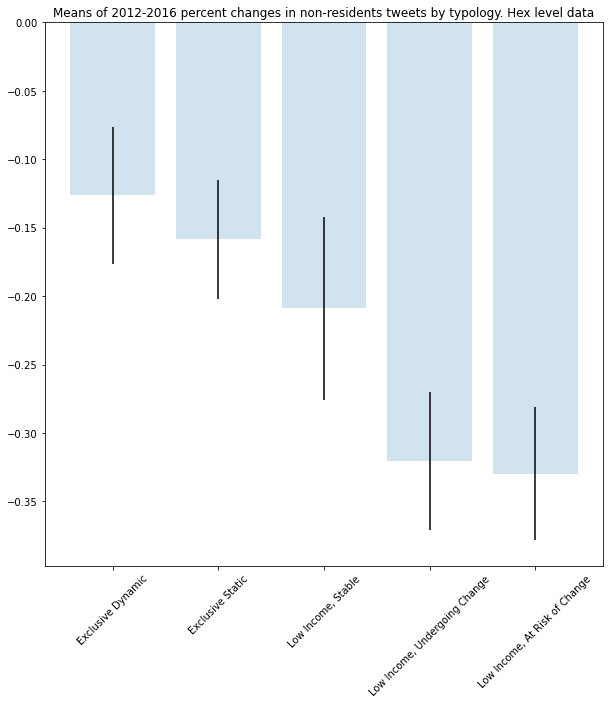

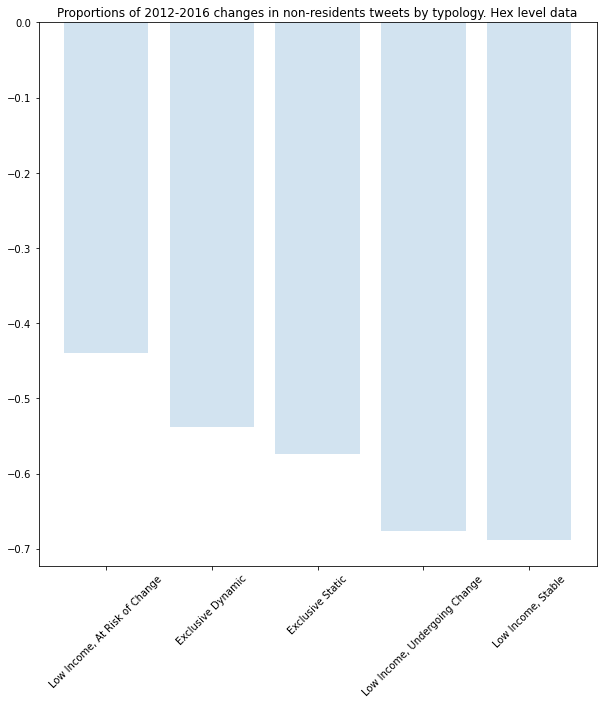

In [71]:
gdfchangesb=a.percent_change_two_periods_df(df, 
                                            datebeforeandafterperiod=datetime.datetime(2014,9,30), 
                                            period_statistic="sum")

#1 Get centroids
gdfchanges_pointsb=myh3.df_with_hexid_to_centroids_gdf(gdfchangesb, hexcolname='_id')

# 3 Spatial Join between centroids and census track shapes
tweets_tractsb=gpd.sjoin(gdfchanges_pointsb, tracts, how="inner", op='intersects')

typo_statsb=tweets_tractsb[['nonresidents_dif','nonresidents_ch', 
                            'nonresidents_p0', 'standardized_types']
                          ].groupby('standardized_types').agg(['mean','count','sem'])

typo_statsb.reset_index(inplace=True)

tweets_tractsb.loc[tweets_tractsb.nonresidents_ch<8].nonresidents_ch.hist()

barchart(tweets_tractsb, 'nonresidents_ch', 
         title='Means of 2012-2016 percent changes in non-residents tweets by typology. Hex level data')

# Create variable proportions to create a bar chart. 
typo_statsb['proportions'] = typo_statsb['nonresidents_dif','mean']/typo_statsb['nonresidents_p0','mean']
typo_statsb = typo_statsb.sort_values(by=('proportions'), ascending=False)

fig, ax = plt.subplots()
    
ax.bar(typo_statsb['standardized_types'], 
       typo_statsb['proportions'],
       alpha=0.2)

plt.title('Proportions of 2012-2016 changes in non-residents tweets by typology. Hex level data')
plt.xticks(rotation=45)
plt.show()

## Filter totalcounts_p0 to >= 100 tweets per hex

In [72]:
tweets_tracts_filter = tweets_tracts[tweets_tracts['totalcounts_p0']>=100]

In [73]:
tweets_tracts_filter

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,OID,SA2_MAINCODE_2016,rentals_ov100_11,types,Typology_ID,standardized_types
6857,89be08cca43ffff,-60.000000,-315.222222,NaN,-315.222222,324.444444,324.444444,NaN,324.444444,-0.971575,...,Greater Sydney,1,New South Wales,110.7146,223,127011505,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"
6862,89be08cca9bffff,-60.000000,-117.833333,NaN,-117.833333,123.333333,123.333333,NaN,123.333333,-0.955405,...,Greater Sydney,1,New South Wales,132.1375,224,127011506,1,1,LI - Low Risk: Gent/Disp,"Low Income, Stable"
4700,89be08c5a0fffff,191.388889,191.388889,NaN,-7.611111,111.111111,111.111111,NaN,111.111111,1.722500,...,Greater Sydney,1,New South Wales,21.5414,157,123011434,1,-1,HI - Stable Exclusion,Exclusive Static
153,89be0840c8bffff,NaN,NaN,NaN,-114.000000,NaN,NaN,200.750000,114.714286,NaN,...,Greater Sydney,1,New South Wales,71.5174,170,124031458,1,-1,HI - Stable Exclusion,Exclusive Static
578,89be084284fffff,-60.000000,-73.333333,NaN,-88.888889,102.888889,87.333333,NaN,102.888889,-0.863931,...,Greater Sydney,1,New South Wales,71.5174,170,124031458,1,-1,HI - Stable Exclusion,Exclusive Static
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13512,89be0e3733bffff,-60.000000,-63.444444,-26.333333,-128.333333,674.555556,577.777778,70.666667,745.222222,-0.151211,...,Greater Sydney,1,New South Wales,2.4605,54,118011340,1,-2,HI - Undergoing Exclusion,Exclusive Dynamic
13513,89be0e37347ffff,-60.000000,-43.222222,-35.208333,-169.111111,154.444444,61.888889,40.875000,190.777778,-0.871942,...,Greater Sydney,1,New South Wales,2.4605,54,118011340,1,-2,HI - Undergoing Exclusion,Exclusive Dynamic
13517,89be0e37367ffff,-60.000000,-160.333333,NaN,-176.111111,190.111111,180.111111,7.125000,196.444444,-0.893045,...,Greater Sydney,1,New South Wales,2.4605,54,118011340,1,-2,HI - Undergoing Exclusion,Exclusive Dynamic
13520,89be0e37373ffff,-60.000000,-181.444444,-23.444444,-211.333333,238.000000,223.333333,27.444444,265.444444,-0.787582,...,Greater Sydney,1,New South Wales,2.4605,54,118011340,1,-2,HI - Undergoing Exclusion,Exclusive Dynamic


In [74]:
typo_stats_f =tweets_tracts_filter[['nonresidents_dif','nonresidents_ch', 
                          'nonresidents_p0', 'standardized_types']
                        ].groupby('standardized_types').agg(['mean','count','sem'])

typo_stats_f.reset_index(inplace=True)

In [75]:
typo_stats_f

standardized_types nonresidents_dif                  \
                                             mean count       sem   
0              Exclusive Dynamic       -51.310516   196  1.514099   
1               Exclusive Static       -42.277933   268  4.374488   
2  Low Income, At Risk of Change       -37.194523   227  6.709814   
3             Low Income, Stable       -49.733889    50  6.426747   
4  Low Income, Undergoing Change       -40.276054   137  4.620830   

  nonresidents_ch                 nonresidents_p0                   
             mean count       sem            mean count        sem  
0       -0.590954   196  0.020462      282.053683   196  22.972376  
1       -0.519480   268  0.047276      238.001592   268  15.934901  
2       -0.543493   227  0.049057      424.298891   228  51.001327  
3       -0.795191    50  0.059844      154.310016    50   9.874989  
4       -0.612212   137  0.066725      183.480799   137  14.329106

In [76]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

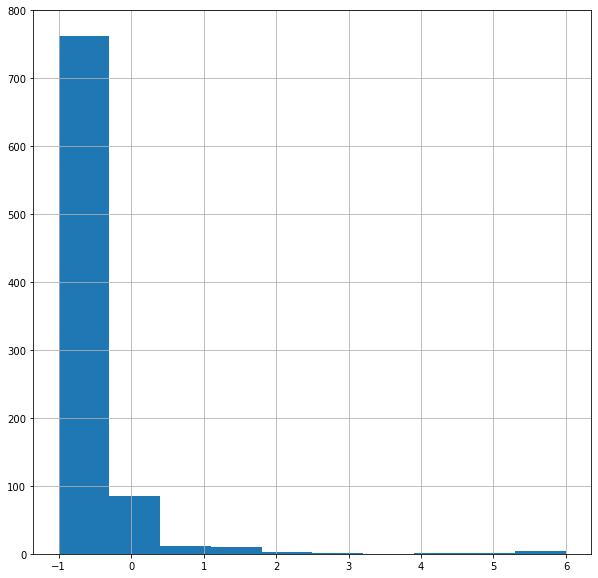

In [77]:
tweets_tracts_filter.loc[tweets_tracts_filter.nonresidents_ch<8].nonresidents_ch.hist()

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


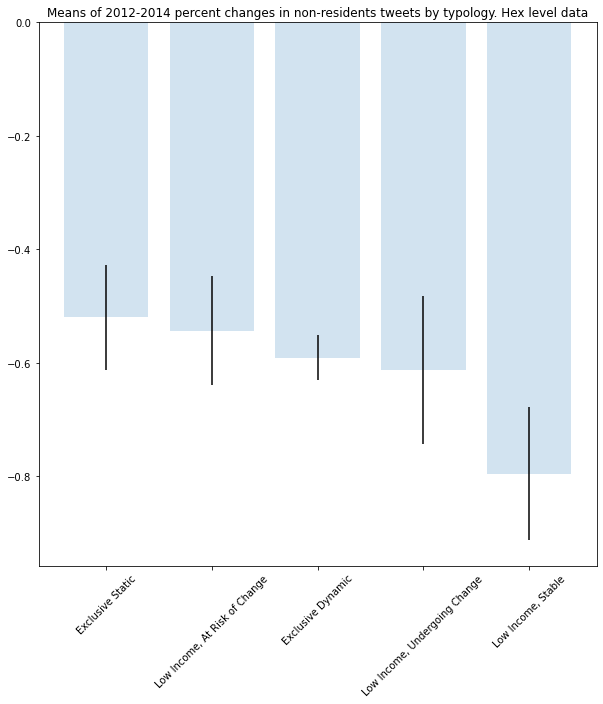

In [78]:
barchart(tweets_tracts_filter, 'nonresidents_ch', 
         title='Means of 2012-2016 percent changes in non-residents tweets by typology. Hex level data')

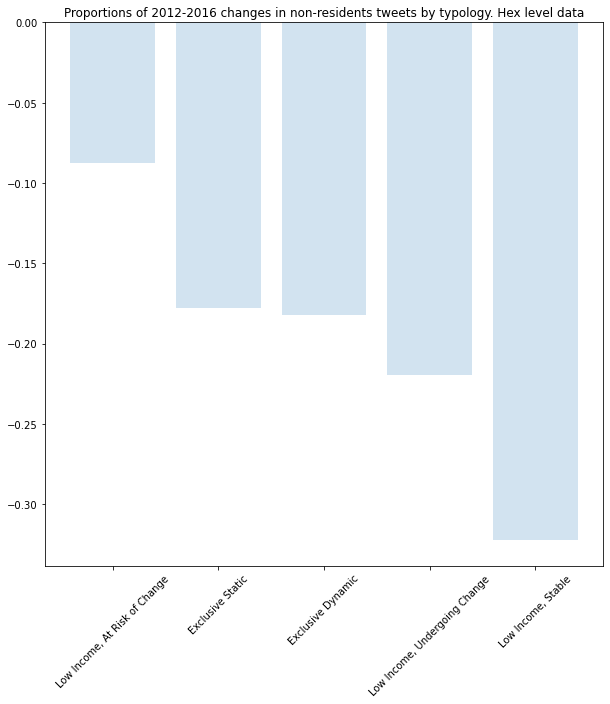

In [85]:
# Create variable proportions to create a bar chart. 
typo_stats_f['proportions'] = typo_stats_f['nonresidents_dif','mean']/typo_stats_f['nonresidents_p0','mean']
typo_stats_f = typo_stats_f.sort_values(by=('proportions'), ascending=False)

fig, ax = plt.subplots()
    
ax.bar(typo_stats_f['standardized_types'], 
       typo_stats_f['proportions'],
       alpha=0.2)

plt.title('Proportions of 2012-2016 changes in non-residents tweets by typology. Hex level data')
plt.xticks(rotation=45)
plt.show()

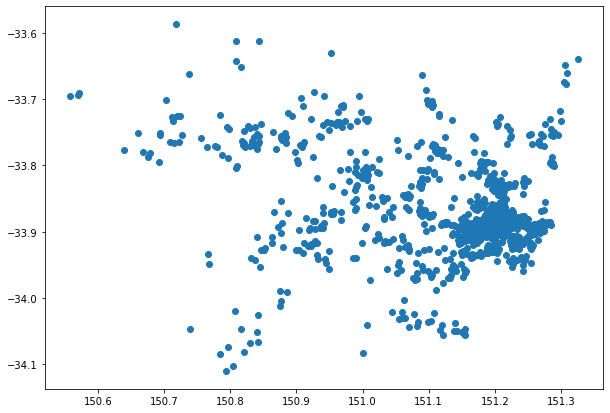

In [80]:
tweets_tracts_filter.plot()

## Repeat analysis summing tweets in each period

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


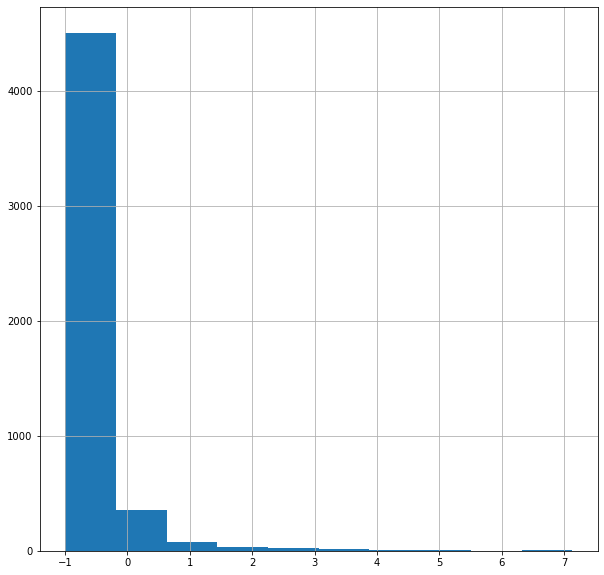

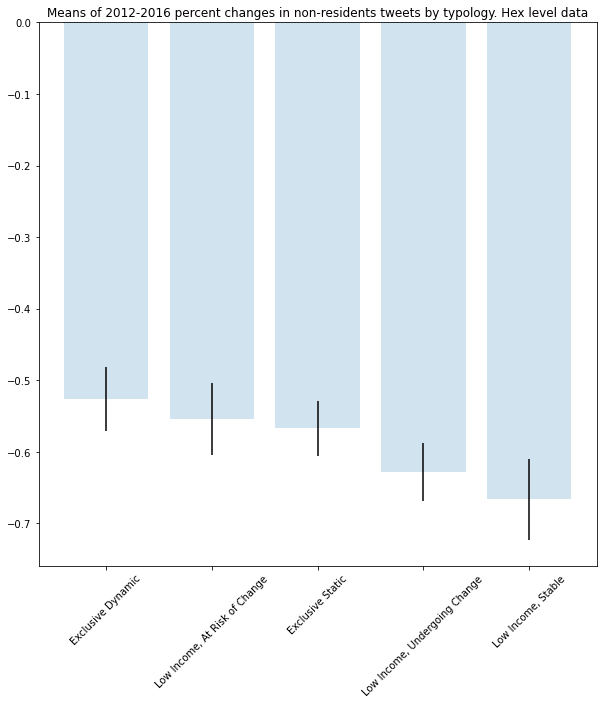

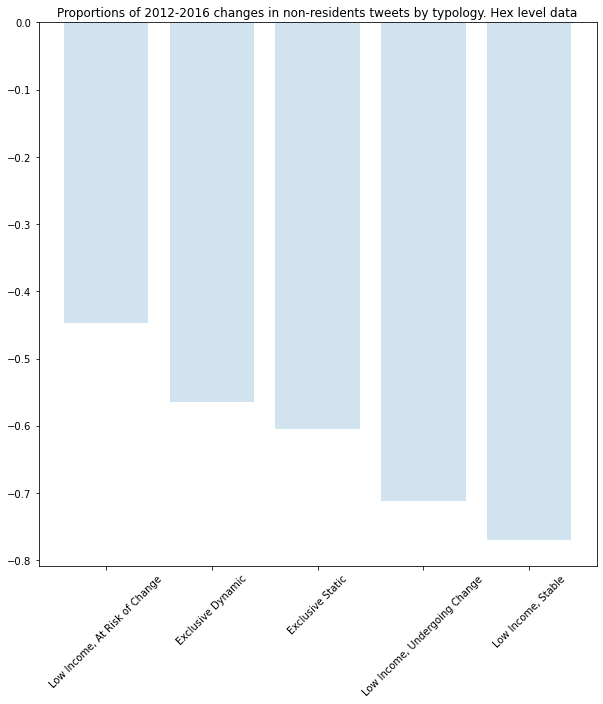

In [86]:
gdfchangesb=a.percent_change_two_periods_df(df, 
                                            datebeforeandafterperiod=datetime.datetime(2014,9,30), 
                                            period_statistic="sum")

#1 Get centroids
gdfchanges_pointsb=myh3.df_with_hexid_to_centroids_gdf(gdfchangesb, 
                                                       hexcolname='_id')

# 3 Spatial Join between centroids and census track shapes
tweets_tractsb=gpd.sjoin(gdfchanges_pointsb, 
                         tracts, 
                         how="inner", 
                         op='intersects')

tweets_tractsb = tweets_tractsb[tweets_tractsb['totalcounts_p0']>=100]

typo_statsb=tweets_tractsb[['nonresidents_dif','nonresidents_ch', 
                            'nonresidents_p0', 'standardized_types']
                          ].groupby('standardized_types').agg(['mean','count','sem'])

typo_statsb.reset_index(inplace=True)

tweets_tractsb.loc[tweets_tractsb.nonresidents_ch<8].nonresidents_ch.hist()

barchart(tweets_tractsb, 'nonresidents_ch', 
         title='Means of 2012-2016 percent changes in non-residents tweets by typology. Hex level data')

# Create variable proportions to create a bar chart. 
typo_statsb['proportions'] = typo_statsb['nonresidents_dif','mean']/typo_statsb['nonresidents_p0','mean']
typo_statsb = typo_statsb.sort_values(by=('proportions'), ascending=False)

fig, ax = plt.subplots()
    
ax.bar(typo_statsb['standardized_types'], 
       typo_statsb['proportions'],
       alpha=0.2)

plt.title('Proportions of 2012-2016 changes in non-residents tweets by typology. Hex level data')
plt.xticks(rotation=45)
plt.show()

## Test: Filter data to only include Hexes with >= 100 tweets per hex

In [89]:
df_gt100 =df[df['totalcounts']>=100]

In [90]:
# 2 Define a midpoint date to separate the two periods in the data. Remember here to change the datetime to the midpoint date in the previous step.
gdfchanges=a.percent_change_two_periods_df(df_gt100, 
                                           datebeforeandafterperiod=datetime.datetime(2014,9,30))

..\analysis.py:954: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['period']=np.where(df.time>datebeforeandafterperiod,1,0)


In [91]:
gdfchanges.head(3)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,89be0842183ffff,1.000000,1.000000,NaN,1.000000,104.000000,104.000000,NaN,104.000000,0.009615,0.009615,NaN,0.009615,0.009615,0.009615,NaN,0.009615,"POLYGON ((150.76187 -33.75872, 150.76138 -33.7..."
1,89be08424dbffff,-213.428571,-215.428571,NaN,-200.428571,357.428571,357.428571,NaN,357.428571,-0.597122,-0.602718,NaN,-0.560751,-0.597122,-0.602718,NaN,-0.560751,"POLYGON ((150.82017 -33.76373, 150.81968 -33.7..."
2,89be0842507ffff,79.000000,79.000000,NaN,79.000000,111.000000,111.000000,NaN,111.000000,0.711712,0.711712,NaN,0.711712,0.711712,0.711712,NaN,0.711712,"POLYGON ((150.77290 -33.76897, 150.77241 -33.7..."


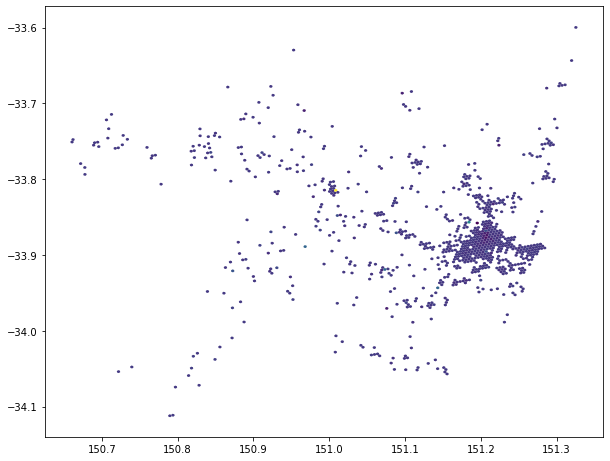

In [92]:
# Plot example
gdfchanges.plot('nonresidents_dif')

### 2.2. Spatial join with census tracks (typologies) data

This requires:

    1. An available function changes the geometry of the gdf to the centroids
    2. Load your typologies data to a geodataframe
    3. Spatial join



In [93]:
#1 Get centroids
gdfchanges_points=myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

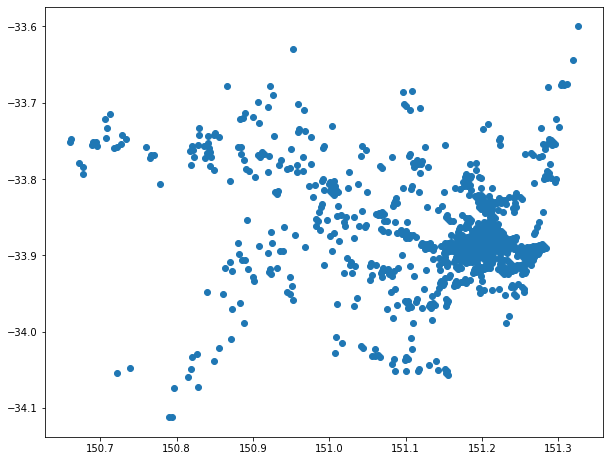

In [94]:
gdfchanges_points.plot()

In [95]:
# 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [96]:
typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 
                          'nonresidents_p0', 'standardized_types']
                        ].groupby('standardized_types').agg(['mean','count','sem'])

typo_stats.reset_index(inplace=True)

In [97]:
typo_stats

standardized_types nonresidents_dif                   \
                                             mean count        sem   
0              Exclusive Dynamic       -79.106207   215  14.557350   
1               Exclusive Static       -52.338812   258  32.765313   
2  Low Income, At Risk of Change        17.926228   212  95.083766   
3             Low Income, Stable       -43.517575    38  41.065214   
4  Low Income, Undergoing Change       -42.789856   117  32.794511   

  nonresidents_ch                 nonresidents_p0                   
             mean count       sem            mean count        sem  
0        0.352115   215  0.265758      294.628045   215  22.261775  
1        0.721871   258  0.397632      295.448645   258  23.283220  
2             inf   212       NaN      467.878837   212  54.429224  
3             inf    38       NaN      264.864693    38  36.630551  
4             inf   117       NaN      282.724155   117  35.292117

In [98]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

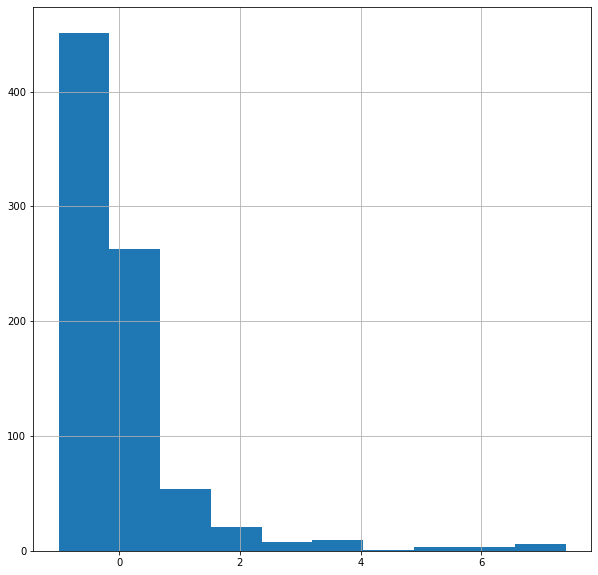

In [99]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

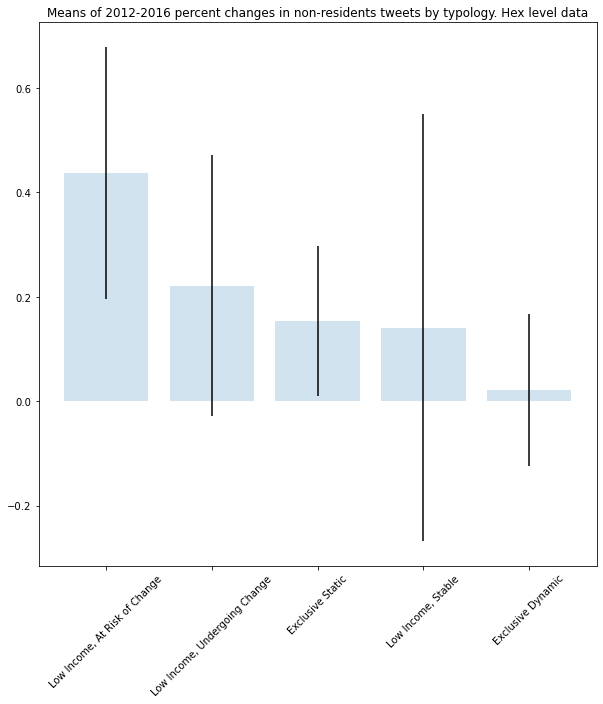

In [100]:
barchart(tweets_tracts, 'nonresidents_ch', 
         title='2012 to 2016 mean percent changes by typology. Hex level data')

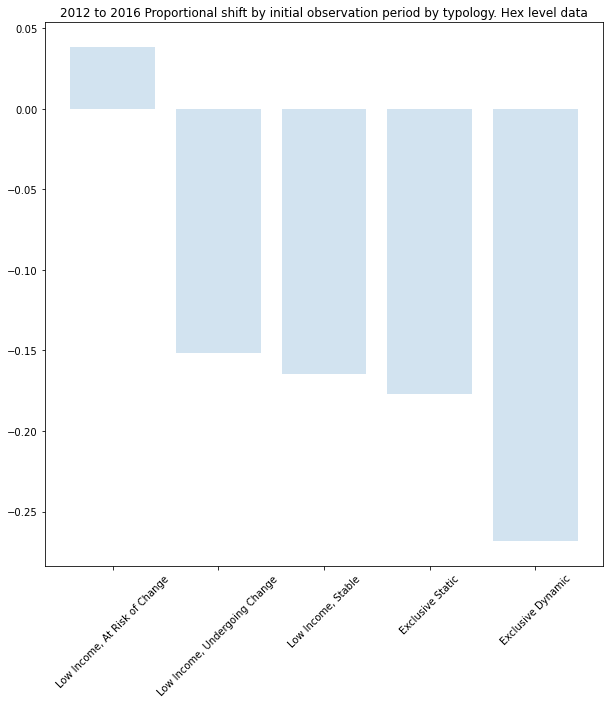

In [102]:
# Create variable proportions to create a bar chart. 
typo_stats['proportions'] = typo_stats['nonresidents_dif','mean']/typo_stats['nonresidents_p0','mean']
typo_stats = typo_stats.sort_values('proportions',ascending=False)

fig, ax = plt.subplots()
    
ax.bar(typo_stats['standardized_types'], 
       typo_stats['proportions'],
       alpha=0.2)

plt.title('2012 to 2016 Proportional shift by initial observation period by typology. Hex level data')
plt.xticks(rotation=45)
plt.show()

Write up: 

So, what this shows is: 

1. That tweets decreased in our period of analysis. We have plenty of confidence about this, though we are not sure whether this is the result of changes in the tweets collection mechanism, actual reduction, or other similar reason.

2. That the area with less decrease is "low income at risk of change", but this can be explained mostly because this category is the one with highest number of tweets in the baseline period, and then results in the lowest percent change. In fact this category was the one with the highest decrease  in levels.

## Update bounding box to only include City of Sydney proper 

In [ ]:
tracts.cx[150.9:151.3, -33.7:-33.95].plot()

In [ ]:
# create bounding box for new spatial analysis 
agg_gdf_new = agg_gdf.cx[150.8:151.3, -33.70:-34]

In [ ]:
agg_gdf_p1 = agg_gdf_new[agg_gdf_new['period']==1]
agg_gdf_p0 =agg_gdf_new[agg_gdf_new['period']==0]

In [ ]:
agg_gdf_p1.plot('nonresidents')

In [ ]:
agg_gdf_p0.plot('nonresidents')